In [1]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.DEBUG)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# deterministic random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

X shape: (1000, 784)
1000


In [17]:
logging.getLogger().setLevel(logging.WARNING)

# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True, num_points=100)

# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=10)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

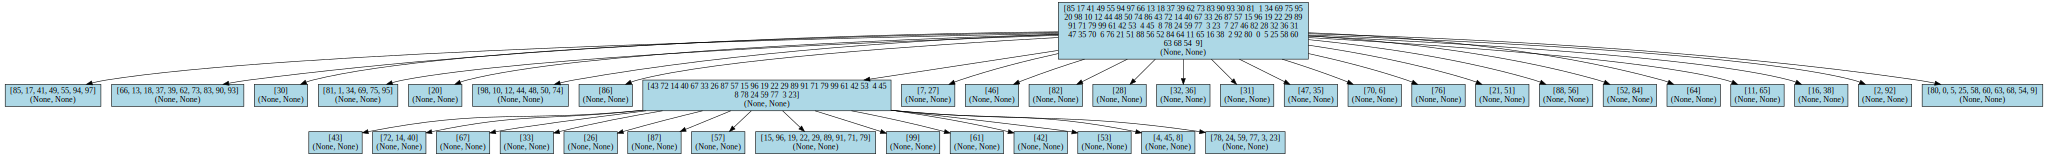

In [18]:
_ = dyadic_sklearn.plot_tree_graphviz()

In [19]:
# Prune nodes with fewer than 50 points
min_points = 10
print(f"\nPruning nodes with fewer than {min_points} points...")
dyadic_sklearn.prune_tree_min_point(min_points)



Pruning nodes with fewer than 10 points...


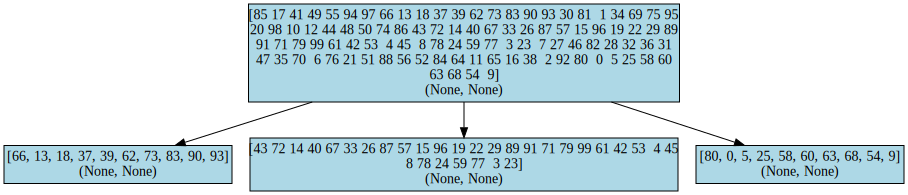

In [20]:
_ = dyadic_sklearn.plot_tree_graphviz()

In [21]:
dyadic_sklearn.fit(X_demo)

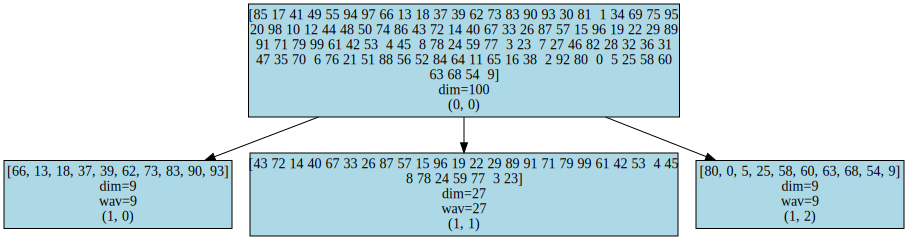

In [22]:
# plot the tree after fit basis
_ = dyadic_sklearn.plot_tree_graphviz(show_basis_dim=True)

In [23]:
logging.getLogger().setLevel(logging.INFO)
feat, leafjk = dyadic_sklearn.fgwt(X_demo)
logging.getLogger().setLevel(logging.DEBUG)
X_reconstructed = dyadic_sklearn.igwt(feat, leafjk, shape=X_demo.shape)

DEBUG:root:Starting inverse GMRA wavelet transform for 100 data points
DEBUG:root:Reconstruction target shape: (100, 784)
DEBUG:root:Reconstructing point 1/100
DEBUG:root:Point 0: starting from leaf (j=1, k=2), 2 coefficient levels
DEBUG:root:Point 0: leaf reconstruction, Qjx shape: (784, 1)
DEBUG:root:Point 0: root level reconstruction, final Qjx shape: (784, 1)
DEBUG:root:Point 0: reconstruction norm: 11.301613
DEBUG:root:***
DEBUG:root:Point 1: starting from leaf (j=1, k=2), 2 coefficient levels
DEBUG:root:Point 1: leaf reconstruction, Qjx shape: (784, 1)
DEBUG:root:Point 1: root level reconstruction, final Qjx shape: (784, 1)
DEBUG:root:***
DEBUG:root:Point 2: starting from leaf (j=1, k=2), 2 coefficient levels
DEBUG:root:Point 2: leaf reconstruction, Qjx shape: (784, 1)
DEBUG:root:Point 2: root level reconstruction, final Qjx shape: (784, 1)
DEBUG:root:***
DEBUG:root:Point 3: starting from leaf (j=1, k=1), 2 coefficient levels
DEBUG:root:Point 3: leaf reconstruction, Qjx shape: (7

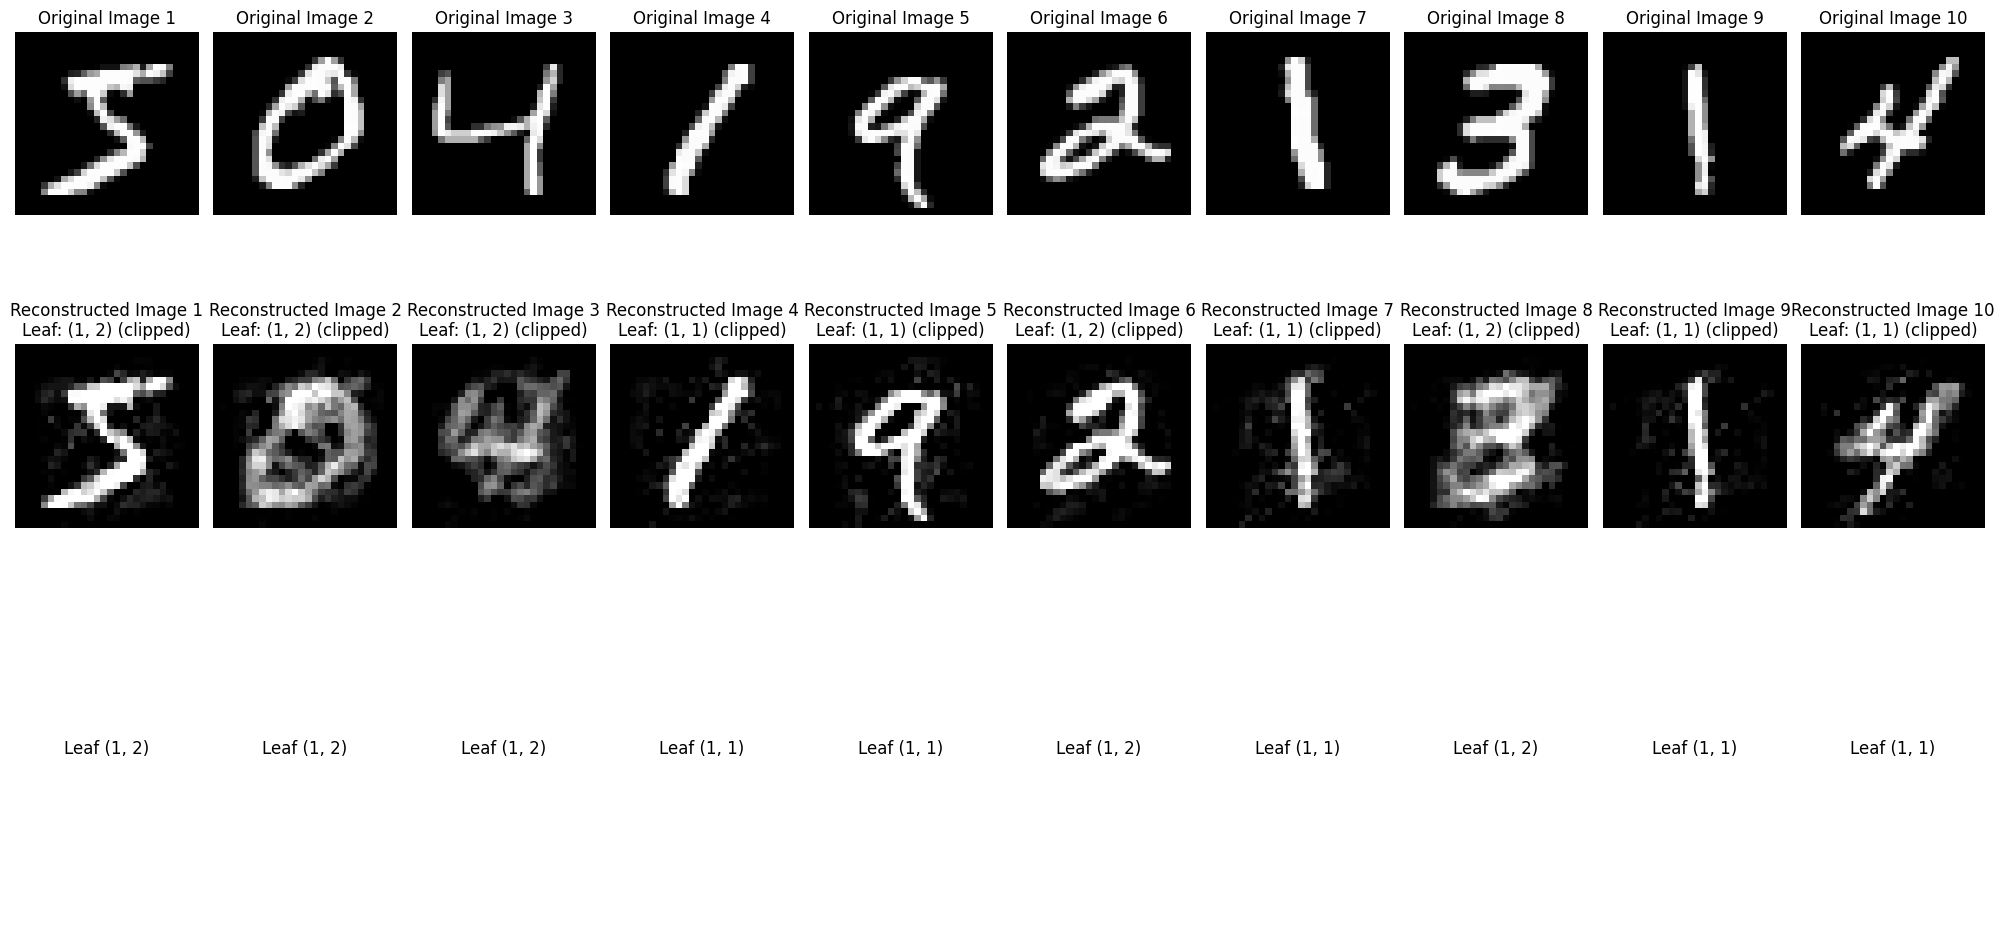

Clipping Statistics:
• Pixels clipped to 0: 21011 (26.80%)
• Pixels clipped to 1: 2612 (3.33%)
• Total pixels clipped: 23623 (30.13%)
• Original range: [-0.831635, 1.641341]
• Clipped range: [0.000000, 1.000000]


In [24]:
# visualize 10 original and reconstructed images
# and note the leaf used for each reconstruction (leaf jk)
# Clip reconstructed images to [0, 1] range for proper visualization

num_images = 10
fig, axes = plt.subplots(3, num_images, figsize=(2 * num_images, 10))

# Clip reconstructed images to [0, 1] range
X_reconstructed_clipped = np.clip(X_reconstructed, 0, 1)

for i in range(num_images):
    axes[0, i].imshow(X_demo[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(X_reconstructed_clipped[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f"Reconstructed Image {i+1}\nLeaf: {leafjk[i]} (clipped)")
    axes[1, i].axis('off')

    axes[2, i].text(0.5, 0.5, f"Leaf {leafjk[i]}", fontsize=12, ha='center', va='center')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Show clipping statistics
print(f"Clipping Statistics:")
print(f"• Pixels clipped to 0: {np.sum(X_reconstructed < 0)} ({np.sum(X_reconstructed < 0)/X_reconstructed.size*100:.2f}%)")
print(f"• Pixels clipped to 1: {np.sum(X_reconstructed > 1)} ({np.sum(X_reconstructed > 1)/X_reconstructed.size*100:.2f}%)")
print(f"• Total pixels clipped: {np.sum((X_reconstructed < 0) | (X_reconstructed > 1))} ({np.sum((X_reconstructed < 0) | (X_reconstructed > 1))/X_reconstructed.size*100:.2f}%)")
print(f"• Original range: [{X_reconstructed.min():.6f}, {X_reconstructed.max():.6f}]")
print(f"• Clipped range: [{X_reconstructed_clipped.min():.6f}, {X_reconstructed_clipped.max():.6f}]")

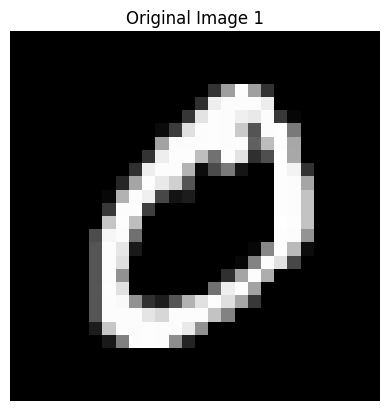

In [10]:
dyadic_sklearn.j_k_to_node[(2,1)].idxs
# plot the original image with index 1
plt.imshow(X_demo[1].reshape(28, 28), cmap='gray')
plt.title(f"Original Image 1")
plt.axis('off')
plt.show()

In [11]:
# Quantitative Analysis of GMRA Reconstruction
print("="*60)
print("QUANTITATIVE ANALYSIS - GMRA RECONSTRUCTION")
print("="*60)

# Basic dataset information
print(f"Dataset Information:")
print(f"• Total images: {len(X_demo)}")
print(f"• Image dimensions: {original_shape_demo}")
print(f"• Flattened size: {X_demo.shape[1]} pixels")
print(f"• Data range: [{X_demo.min():.3f}, {X_demo.max():.3f}]")

# Value range analysis - Original vs Reconstructed
print(f"\nValue Range Analysis:")
print(f"• Original images:")
print(f"  - Min value: {X_demo.min():.6f}")
print(f"  - Max value: {X_demo.max():.6f}")
print(f"  - Mean value: {X_demo.mean():.6f}")
print(f"  - Std value: {X_demo.std():.6f}")

print(f"• Reconstructed images:")
print(f"  - Min value: {X_reconstructed.min():.6f}")
print(f"  - Max value: {X_reconstructed.max():.6f}")
print(f"  - Mean value: {X_reconstructed.mean():.6f}")
print(f"  - Std value: {X_reconstructed.std():.6f}")

# Value range comparison
print(f"• Value range differences:")
print(f"  - Min difference: {X_reconstructed.min() - X_demo.min():.6f}")
print(f"  - Max difference: {X_reconstructed.max() - X_demo.max():.6f}")
print(f"  - Mean difference: {X_reconstructed.mean() - X_demo.mean():.6f}")
print(f"  - Std difference: {X_reconstructed.std() - X_demo.std():.6f}")

# Check for out-of-range values
original_range = (X_demo.min(), X_demo.max())
out_of_range_low = np.sum(X_reconstructed < original_range[0])
out_of_range_high = np.sum(X_reconstructed > original_range[1])
total_pixels = X_reconstructed.size

print(f"• Out-of-range pixels in reconstruction:")
print(f"  - Below original min ({original_range[0]:.3f}): {out_of_range_low} pixels ({out_of_range_low/total_pixels*100:.2f}%)")
print(f"  - Above original max ({original_range[1]:.3f}): {out_of_range_high} pixels ({out_of_range_high/total_pixels*100:.2f}%)")

# Tree structure analysis
print(f"\nTree Structure:")
print(f"• Tree height: {dyadic_sklearn.height}")
print(f"• Total nodes: {len(dyadic_sklearn.get_all_nodes())}")
print(f"• Leaf nodes: {len(dyadic_sklearn.get_all_leafs())}")
print(f"• Pruning threshold: {min_points} points minimum")

# Reconstruction quality analysis
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate reconstruction errors
mse_total = mean_squared_error(X_demo, X_reconstructed)
mae_total = mean_absolute_error(X_demo, X_reconstructed)
rmse_total = np.sqrt(mse_total)

# Calculate per-image errors
mse_per_image = [mean_squared_error(X_demo[i:i+1], X_reconstructed[i:i+1]) for i in range(len(X_demo))]
mae_per_image = [mean_absolute_error(X_demo[i:i+1], X_reconstructed[i:i+1]) for i in range(len(X_demo))]

print(f"\nReconstruction Quality:")
print(f"• Mean Squared Error (MSE): {mse_total:.6f}")
print(f"• Root Mean Squared Error (RMSE): {rmse_total:.6f}")
print(f"• Mean Absolute Error (MAE): {mae_total:.6f}")
print(f"• Max per-image MSE: {max(mse_per_image):.6f}")
print(f"• Min per-image MSE: {min(mse_per_image):.6f}")
print(f"• Std per-image MSE: {np.std(mse_per_image):.6f}")

# Leaf distribution analysis
leafs = dyadic_sklearn.get_all_leafs()
leaf_sizes = [len(leaf.idxs) for leaf in leafs]
leaf_usage = {}
for jk in leafjk:
    leaf_usage[jk] = leaf_usage.get(jk, 0) + 1

print(f"\nLeaf Node Analysis:")
print(f"• Total leaf nodes: {len(leafs)}")
print(f"• Leaf sizes - Min: {min(leaf_sizes)}, Max: {max(leaf_sizes)}, Mean: {np.mean(leaf_sizes):.1f}")
print(f"• Unique leaves used for reconstruction: {len(leaf_usage)}")
print(f"• Leaf usage distribution:")
for jk, count in sorted(leaf_usage.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  - Leaf {jk}: {count} images ({count/len(X_demo)*100:.1f}%)")

# Basis dimension analysis (if available)
if hasattr(dyadic_sklearn.root, 'basis') and dyadic_sklearn.root.basis is not None:
    print(f"\nBasis Dimensions:")
    all_nodes = dyadic_sklearn.get_all_nodes()
    basis_dims = []
    wav_basis_dims = []
    
    for node in all_nodes:
        if hasattr(node, 'basis') and node.basis is not None:
            basis_dims.append(node.basis.shape[0])
        if hasattr(node, 'wav_basis') and node.wav_basis is not None:
            wav_basis_dims.append(node.wav_basis.shape[0])
    
    if basis_dims:
        print(f"• Basis dimensions - Min: {min(basis_dims)}, Max: {max(basis_dims)}, Mean: {np.mean(basis_dims):.1f}")
    if wav_basis_dims:
        print(f"• Wavelet basis dimensions - Min: {min(wav_basis_dims)}, Max: {max(wav_basis_dims)}, Mean: {np.mean(wav_basis_dims):.1f}")

# Compression analysis
print(f"\nCompression Analysis:")
# Original storage: num_images * pixels_per_image
original_storage = len(X_demo) * X_demo.shape[1]

# GMRA storage: tree structure + coefficients
# This is a simplified estimate
num_coeffs_per_image = sum(len(coeff) for coeff in feat) // len(feat) if feat else 0
gmra_storage = len(dyadic_sklearn.get_all_nodes()) * 100 + len(X_demo) * num_coeffs_per_image  # Rough estimate

print(f"• Original storage (pixels): {original_storage}")
print(f"• Estimated GMRA storage: {gmra_storage}")
if gmra_storage > 0:
    compression_ratio = original_storage / gmra_storage
    print(f"• Estimated compression ratio: {compression_ratio:.2f}x")

# Signal-to-noise ratio
signal_power = np.mean(X_demo ** 2)
noise_power = np.mean((X_demo - X_reconstructed) ** 2)
snr_db = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

print(f"\nSignal Quality:")
print(f"• Signal-to-Noise Ratio (SNR): {snr_db:.2f} dB")
print(f"• Reconstruction fidelity: {(1 - noise_power/signal_power)*100:.2f}%")

print(f"\n" + "="*60)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 100 leaf nodes


QUANTITATIVE ANALYSIS - GMRA RECONSTRUCTION
Dataset Information:
• Total images: 100
• Image dimensions: (100, 1, 28, 28)
• Flattened size: 784 pixels
• Data range: [0.000, 1.000]

Value Range Analysis:
• Original images:
  - Min value: 0.000000
  - Max value: 1.000000
  - Mean value: 0.126595
  - Std value: 0.303224
• Reconstructed images:
  - Min value: -0.569030
  - Max value: 1.771708
  - Mean value: 0.126595
  - Std value: 0.316964
• Value range differences:
  - Min difference: -0.569030
  - Max difference: 0.771708
  - Mean difference: 0.000000
  - Std difference: 0.013740
• Out-of-range pixels in reconstruction:
  - Below original min (0.000): 23056 pixels (29.41%)
  - Above original max (1.000): 2770 pixels (3.53%)

Tree Structure:
• Tree height: 4
• Total nodes: 117
• Leaf nodes: 100
• Pruning threshold: 1 points minimum


DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 100 leaf nodes



Reconstruction Quality:
• Mean Squared Error (MSE): 0.002890
• Root Mean Squared Error (RMSE): 0.053761
• Mean Absolute Error (MAE): 0.024001
• Max per-image MSE: 0.012661
• Min per-image MSE: 0.000000
• Std per-image MSE: 0.003115

Leaf Node Analysis:
• Total leaf nodes: 100
• Leaf sizes - Min: 1, Max: 1, Mean: 1.0
• Unique leaves used for reconstruction: 100
• Leaf usage distribution:
  - Leaf (1, 21): 1 images (1.0%)
  - Leaf (2, 1): 1 images (1.0%)
  - Leaf (1, 26): 1 images (1.0%)
  - Leaf (3, 6): 1 images (1.0%)
  - Leaf (2, 64): 1 images (1.0%)

Basis Dimensions:
• Basis dimensions - Min: 0, Max: 100, Mean: 1.6
• Wavelet basis dimensions - Min: 0, Max: 23, Mean: 0.7

Compression Analysis:
• Original storage (pixels): 78400
• Estimated GMRA storage: 11900
• Estimated compression ratio: 6.59x

Signal Quality:
• Signal-to-Noise Ratio (SNR): 15.72 dB
• Reconstruction fidelity: 97.32%



Creating stem plot of reconstruction errors...


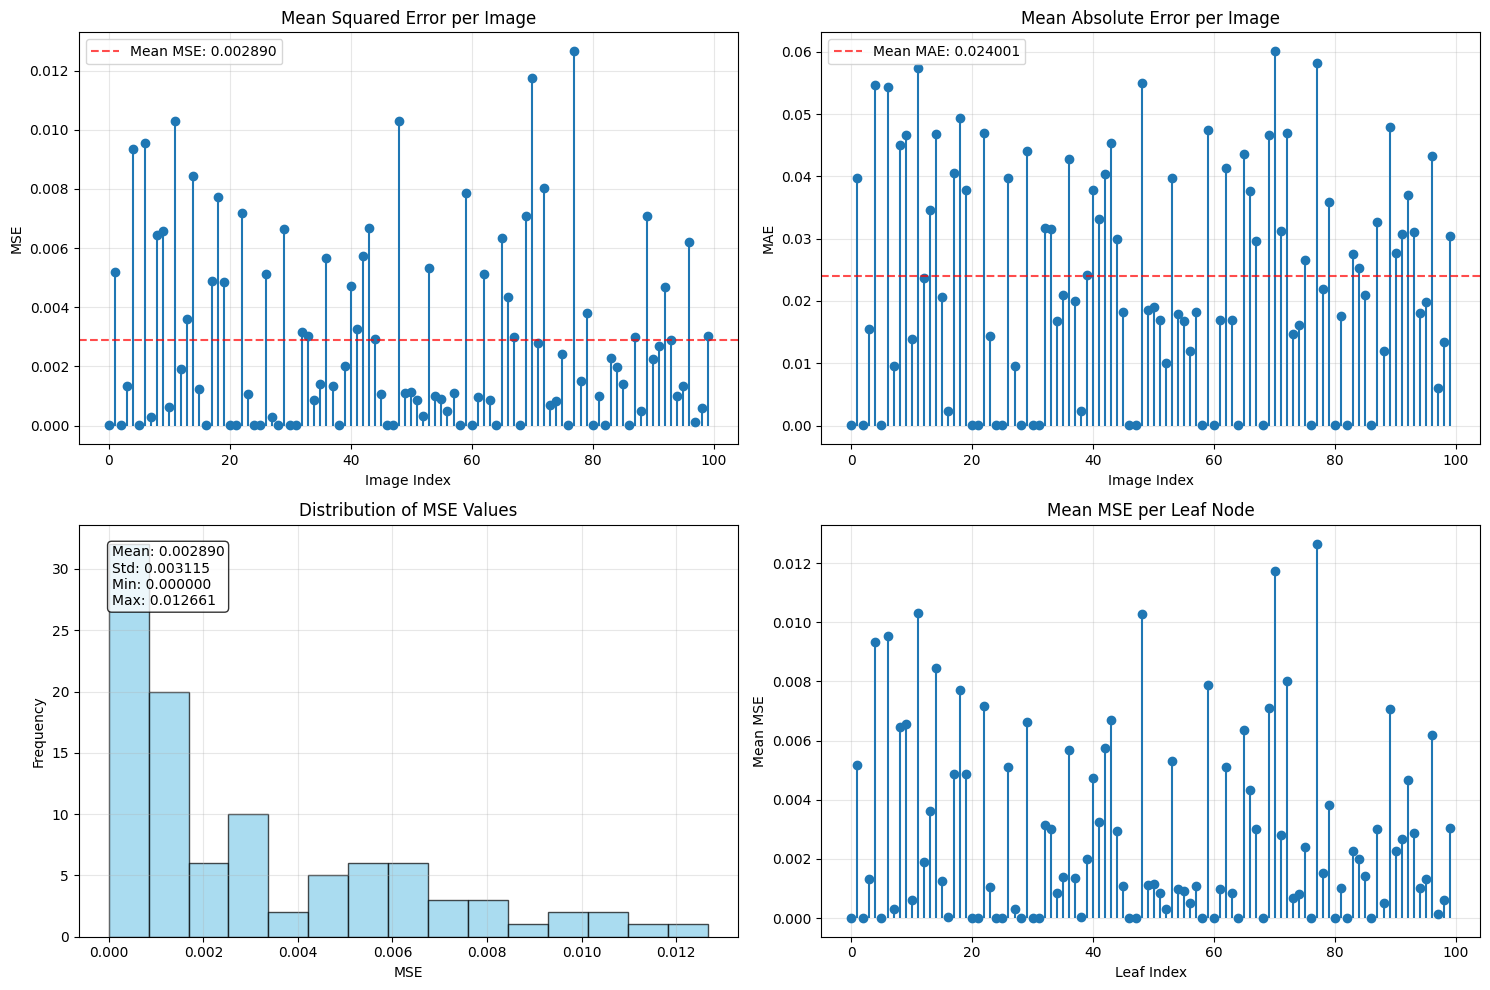


Detailed Error Statistics:
• MSE Statistics:
  - Mean: 0.002890
  - Std: 0.003115
  - Min: 0.000000 (Image 46)
  - Max: 0.012661 (Image 77)
  - Median: 0.001406

• MAE Statistics:
  - Mean: 0.024001
  - Std: 0.017636
  - Min: 0.000000 (Image 0)
  - Max: 0.060126 (Image 70)
  - Median: 0.020913

• Leaf Node Error Analysis:
  - Best performing leaf: (1, 27) (MSE: 0.000000)
  - Worst performing leaf: (3, 3) (MSE: 0.012661)
  - Leaf error range: 0.012661

• Worst Performing Images (Top 5):
  1. Image 77: MSE=0.012661, MAE=0.058230, Leaf=(3, 3)
  2. Image 70: MSE=0.011742, MAE=0.060126, Leaf=(2, 14)
  3. Image 11: MSE=0.010307, MAE=0.057337, Leaf=(2, 8)
  4. Image 48: MSE=0.010283, MAE=0.055037, Leaf=(2, 16)
  5. Image 6: MSE=0.009552, MAE=0.054334, Leaf=(2, 9)

• Best Performing Images (Top 5):
  1. Image 46: MSE=0.000000, MAE=0.000000, Leaf=(1, 27)
  2. Image 0: MSE=0.000000, MAE=0.000000, Leaf=(1, 21)
  3. Image 5: MSE=0.000000, MAE=0.000000, Leaf=(1, 20)
  4. Image 31: MSE=0.000000, MA

In [12]:
# Stem Plot of Reconstruction Errors per Data Point
print("Creating stem plot of reconstruction errors...")

# Calculate per-image reconstruction errors
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_per_image = [mean_squared_error(X_demo[i:i+1], X_reconstructed[i:i+1]) for i in range(len(X_demo))]
mae_per_image = [mean_absolute_error(X_demo[i:i+1], X_reconstructed[i:i+1]) for i in range(len(X_demo))]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. MSE Stem Plot
axes[0, 0].stem(range(len(mse_per_image)), mse_per_image, basefmt=" ")
axes[0, 0].set_title('Mean Squared Error per Image')
axes[0, 0].set_xlabel('Image Index')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].grid(True, alpha=0.3)

# Add horizontal line for mean MSE
mean_mse = np.mean(mse_per_image)
axes[0, 0].axhline(y=mean_mse, color='red', linestyle='--', alpha=0.7, label=f'Mean MSE: {mean_mse:.6f}')
axes[0, 0].legend()

# 2. MAE Stem Plot
axes[0, 1].stem(range(len(mae_per_image)), mae_per_image, basefmt=" ")
axes[0, 1].set_title('Mean Absolute Error per Image')
axes[0, 1].set_xlabel('Image Index')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True, alpha=0.3)

# Add horizontal line for mean MAE
mean_mae = np.mean(mae_per_image)
axes[0, 1].axhline(y=mean_mae, color='red', linestyle='--', alpha=0.7, label=f'Mean MAE: {mean_mae:.6f}')
axes[0, 1].legend()

# 3. Error Distribution Histogram
axes[1, 0].hist(mse_per_image, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Distribution of MSE Values')
axes[1, 0].set_xlabel('MSE')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Add statistics text
stats_text = f'Mean: {np.mean(mse_per_image):.6f}\nStd: {np.std(mse_per_image):.6f}\nMin: {np.min(mse_per_image):.6f}\nMax: {np.max(mse_per_image):.6f}'
axes[1, 0].text(0.05, 0.95, stats_text, transform=axes[1, 0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Leaf Usage vs Error
leaf_errors = {}
for i, (jk, mse) in enumerate(zip(leafjk, mse_per_image)):
    if jk not in leaf_errors:
        leaf_errors[jk] = []
    leaf_errors[jk].append(mse)

# Calculate mean error per leaf
leaf_mean_errors = {jk: np.mean(errors) for jk, errors in leaf_errors.items()}
leaf_names = list(leaf_mean_errors.keys())
leaf_means = list(leaf_mean_errors.values())

axes[1, 1].stem(range(len(leaf_names)), leaf_means, basefmt=" ")
axes[1, 1].set_title('Mean MSE per Leaf Node')
axes[1, 1].set_xlabel('Leaf Index')
axes[1, 1].set_ylabel('Mean MSE')
axes[1, 1].grid(True, alpha=0.3)

# Set x-axis labels to show leaf names
if len(leaf_names) <= 20:  # Only show labels if not too many
    axes[1, 1].set_xticks(range(len(leaf_names)))
    axes[1, 1].set_xticklabels([str(jk) for jk in leaf_names], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed error statistics
print(f"\nDetailed Error Statistics:")
print(f"• MSE Statistics:")
print(f"  - Mean: {np.mean(mse_per_image):.6f}")
print(f"  - Std: {np.std(mse_per_image):.6f}")
print(f"  - Min: {np.min(mse_per_image):.6f} (Image {np.argmin(mse_per_image)})")
print(f"  - Max: {np.max(mse_per_image):.6f} (Image {np.argmax(mse_per_image)})")
print(f"  - Median: {np.median(mse_per_image):.6f}")

print(f"\n• MAE Statistics:")
print(f"  - Mean: {np.mean(mae_per_image):.6f}")
print(f"  - Std: {np.std(mae_per_image):.6f}")
print(f"  - Min: {np.min(mae_per_image):.6f} (Image {np.argmin(mae_per_image)})")
print(f"  - Max: {np.max(mae_per_image):.6f} (Image {np.argmax(mae_per_image)})")
print(f"  - Median: {np.median(mae_per_image):.6f}")

print(f"\n• Leaf Node Error Analysis:")
print(f"  - Best performing leaf: {min(leaf_mean_errors.keys(), key=lambda k: leaf_mean_errors[k])} (MSE: {min(leaf_mean_errors.values()):.6f})")
print(f"  - Worst performing leaf: {max(leaf_mean_errors.keys(), key=lambda k: leaf_mean_errors[k])} (MSE: {max(leaf_mean_errors.values()):.6f})")
print(f"  - Leaf error range: {max(leaf_mean_errors.values()) - min(leaf_mean_errors.values()):.6f}")

# Show worst performing images
print(f"\n• Worst Performing Images (Top 5):")
worst_indices = np.argsort(mse_per_image)[-5:][::-1]
for i, idx in enumerate(worst_indices):
    print(f"  {i+1}. Image {idx}: MSE={mse_per_image[idx]:.6f}, MAE={mae_per_image[idx]:.6f}, Leaf={leafjk[idx]}")

# Show best performing images
print(f"\n• Best Performing Images (Top 5):")
best_indices = np.argsort(mse_per_image)[:5]
for i, idx in enumerate(best_indices):
    print(f"  {i+1}. Image {idx}: MSE={mse_per_image[idx]:.6f}, MAE={mae_per_image[idx]:.6f}, Leaf={leafjk[idx]}")

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 100 leaf nodes


Analyzing correlation between reconstruction error and distance from leaf center...
Found 100 leaf centers
Sample leaf keys: [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]
Sample leafjk values: [(1, 21), (2, 1), (1, 26), (3, 6), (2, 64)]
Valid distance calculations: 100 out of 100

Correlation Analysis:
• Distance vs MSE:
  - Pearson correlation: nan (p-value: nan)
  - Spearman correlation: nan (p-value: nan)
• Distance vs MAE:
  - Pearson correlation: nan (p-value: nan)
  - Spearman correlation: nan (p-value: nan)
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/scratch/f006pq6/softwares/miniconda3/envs/gmra/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/scratch/f006pq6/softwares/miniconda3/envs/gmra/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/scratch/f006pq6/softwares/miniconda3/envs/gmra/lib/python3.8/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

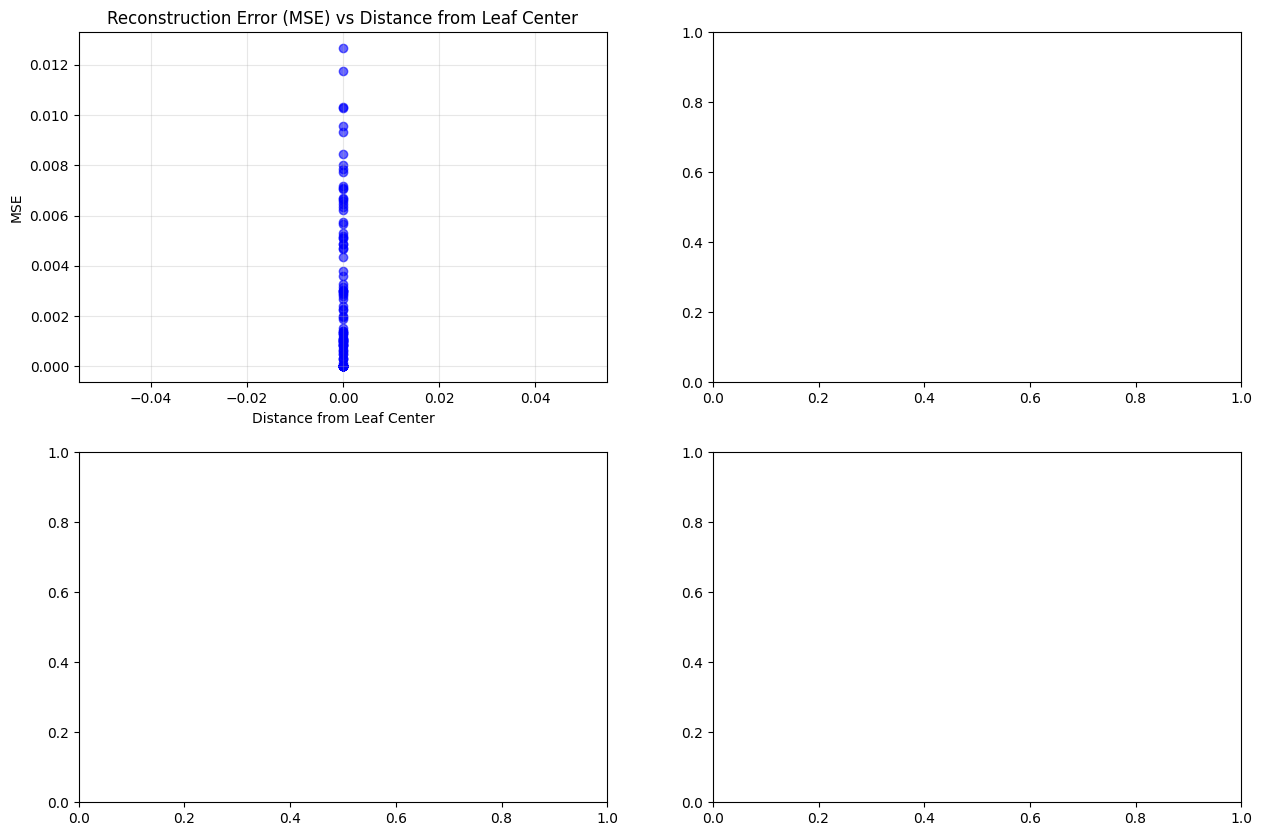

In [13]:
# Analysis: Reconstruction Error vs Distance from Leaf Center
print("Analyzing correlation between reconstruction error and distance from leaf center...")

# Calculate distance from each image to its assigned leaf center
distances_to_center = []
leaf_centers = {}

# First, get all leaf nodes and their centers
all_leafs = dyadic_sklearn.get_all_leafs()
for leaf in all_leafs:
    if len(leaf.idxs) > 0:
        # Calculate center of leaf as mean of its points
        leaf_points = X_demo[leaf.idxs]
        leaf_center = np.mean(leaf_points, axis=0)
        # Use (node_j, node_k) tuple as key, matching the leafjk format
        leaf_key = (leaf.node_j, leaf.node_k)
        leaf_centers[leaf_key] = leaf_center

print(f"Found {len(leaf_centers)} leaf centers")
print(f"Sample leaf keys: {list(leaf_centers.keys())[:5]}")
print(f"Sample leafjk values: {leafjk[:5]}")

# Calculate distance from each image to its assigned leaf center
for i, jk in enumerate(leafjk):
    if jk in leaf_centers:
        distance = np.linalg.norm(X_demo[i] - leaf_centers[jk])
        distances_to_center.append(distance)
    else:
        # Fallback: find the leaf node by searching through all leafs
        target_leaf = None
        for leaf in all_leafs:
            if (leaf.node_j, leaf.node_k) == jk:
                target_leaf = leaf
                break
        
        if target_leaf and len(target_leaf.idxs) > 0:
            leaf_points = X_demo[target_leaf.idxs]
            leaf_center = np.mean(leaf_points, axis=0)
            distance = np.linalg.norm(X_demo[i] - leaf_center)
            distances_to_center.append(distance)
        else:
            # If we can't find the leaf, use a large distance as placeholder
            print(f"Warning: Could not find leaf {jk} for image {i}")
            distances_to_center.append(np.nan)

# Convert to numpy array
distances_to_center = np.array(distances_to_center)

# Remove any NaN values
valid_indices = ~np.isnan(distances_to_center)
valid_distances = distances_to_center[valid_indices]
valid_mse = np.array(mse_per_image)[valid_indices]
valid_mae = np.array(mae_per_image)[valid_indices]

print(f"Valid distance calculations: {len(valid_distances)} out of {len(distances_to_center)}")

# Calculate correlation coefficients
from scipy.stats import pearsonr, spearmanr

if len(valid_distances) > 1:
    pearson_mse, p_value_pearson_mse = pearsonr(valid_distances, valid_mse)
    spearman_mse, p_value_spearman_mse = spearmanr(valid_distances, valid_mse)
    
    pearson_mae, p_value_pearson_mae = pearsonr(valid_distances, valid_mae)
    spearman_mae, p_value_spearman_mae = spearmanr(valid_distances, valid_mae)
    
    print(f"\nCorrelation Analysis:")
    print(f"• Distance vs MSE:")
    print(f"  - Pearson correlation: {pearson_mse:.4f} (p-value: {p_value_pearson_mse:.4f})")
    print(f"  - Spearman correlation: {spearman_mse:.4f} (p-value: {p_value_spearman_mse:.4f})")
    
    print(f"• Distance vs MAE:")
    print(f"  - Pearson correlation: {pearson_mae:.4f} (p-value: {p_value_pearson_mae:.4f})")
    print(f"  - Spearman correlation: {spearman_mae:.4f} (p-value: {p_value_spearman_mae:.4f})")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Scatter plot: Distance vs MSE
axes[0, 0].scatter(valid_distances, valid_mse, alpha=0.6, color='blue')
axes[0, 0].set_xlabel('Distance from Leaf Center')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Reconstruction Error (MSE) vs Distance from Leaf Center')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
if len(valid_distances) > 1:
    z = np.polyfit(valid_distances, valid_mse, 1)
    p = np.poly1d(z)
    axes[0, 0].plot(valid_distances, p(valid_distances), "r--", alpha=0.8, 
                    label=f'Trend line (r={pearson_mse:.3f})')
    axes[0, 0].legend()

# 2. Scatter plot: Distance vs MAE
axes[0, 1].scatter(valid_distances, valid_mae, alpha=0.6, color='green')
axes[0, 1].set_xlabel('Distance from Leaf Center')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Reconstruction Error (MAE) vs Distance from Leaf Center')
axes[0, 1].grid(True, alpha=0.3)

# Add trend line
if len(valid_distances) > 1:
    z = np.polyfit(valid_distances, valid_mae, 1)
    p = np.poly1d(z)
    axes[0, 1].plot(valid_distances, p(valid_distances), "r--", alpha=0.8,
                    label=f'Trend line (r={pearson_mae:.3f})')
    axes[0, 1].legend()

# 3. Histogram of distances
axes[1, 0].hist(valid_distances, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Distance from Leaf Center')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Distances from Leaf Centers')
axes[1, 0].grid(True, alpha=0.3)

# Add statistics
dist_stats = f'Mean: {np.mean(valid_distances):.3f}\nStd: {np.std(valid_distances):.3f}\nMin: {np.min(valid_distances):.3f}\nMax: {np.max(valid_distances):.3f}'
axes[1, 0].text(0.05, 0.95, dist_stats, transform=axes[1, 0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Binned analysis: Average error by distance range
if len(valid_distances) > 10:
    # Create distance bins
    n_bins = 5
    bin_edges = np.linspace(np.min(valid_distances), np.max(valid_distances), n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate mean error in each bin
    bin_mse_means = []
    bin_mse_stds = []
    bin_counts = []
    
    for i in range(n_bins):
        mask = (valid_distances >= bin_edges[i]) & (valid_distances < bin_edges[i + 1])
        if i == n_bins - 1:  # Include the last edge
            mask = (valid_distances >= bin_edges[i]) & (valid_distances <= bin_edges[i + 1])
        
        if np.sum(mask) > 0:
            bin_mse_means.append(np.mean(valid_mse[mask]))
            bin_mse_stds.append(np.std(valid_mse[mask]))
            bin_counts.append(np.sum(mask))
        else:
            bin_mse_means.append(0)
            bin_mse_stds.append(0)
            bin_counts.append(0)
    
    # Bar plot with error bars
    bars = axes[1, 1].bar(range(n_bins), bin_mse_means, yerr=bin_mse_stds, 
                         alpha=0.7, color='purple', capsize=5)
    axes[1, 1].set_xlabel('Distance Bin')
    axes[1, 1].set_ylabel('Mean MSE')
    axes[1, 1].set_title('Mean MSE by Distance Range')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Set x-axis labels
    bin_labels = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(n_bins)]
    axes[1, 1].set_xticks(range(n_bins))
    axes[1, 1].set_xticklabels(bin_labels, rotation=45, ha='right')
    
    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars, bin_counts)):
        if count > 0:
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bin_mse_stds[i],
                           f'n={count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\nDetailed Distance Analysis:")
print(f"• Distance Statistics:")
print(f"  - Mean distance: {np.mean(valid_distances):.4f}")
print(f"  - Std distance: {np.std(valid_distances):.4f}")
print(f"  - Min distance: {np.min(valid_distances):.4f}")
print(f"  - Max distance: {np.max(valid_distances):.4f}")
print(f"  - Median distance: {np.median(valid_distances):.4f}")

# Find images with highest distances and their errors
if len(valid_distances) > 0:
    # Get original indices (accounting for any removed NaN values)
    original_indices = np.arange(len(distances_to_center))[valid_indices]
    
    # Sort by distance
    distance_order = np.argsort(valid_distances)[::-1]  # Highest first
    
    print(f"\n• Images with Highest Distances from Leaf Center:")
    for i in range(min(5, len(distance_order))):
        idx = distance_order[i]
        orig_idx = original_indices[idx]
        print(f"  {i+1}. Image {orig_idx}: Distance={valid_distances[idx]:.4f}, MSE={valid_mse[idx]:.6f}, MAE={valid_mae[idx]:.6f}, Leaf={leafjk[orig_idx]}")
    
    print(f"\n• Images with Lowest Distances from Leaf Center:")
    for i in range(min(5, len(distance_order))):
        idx = distance_order[-(i+1)]  # Lowest first
        orig_idx = original_indices[idx]
        print(f"  {i+1}. Image {orig_idx}: Distance={valid_distances[idx]:.4f}, MSE={valid_mse[idx]:.6f}, MAE={valid_mae[idx]:.6f}, Leaf={leafjk[orig_idx]}")

# Leaf-specific analysis
print(f"\n• Leaf-Specific Analysis:")
leaf_distance_stats = {}
for i, jk in enumerate(leafjk):
    if valid_indices[i]:  # Only consider valid distances
        valid_idx = np.where(original_indices == i)[0]
        if len(valid_idx) > 0:
            distance = valid_distances[valid_idx[0]]
            mse = valid_mse[valid_idx[0]]
            
            if jk not in leaf_distance_stats:
                leaf_distance_stats[jk] = {'distances': [], 'mses': [], 'maes': []}
            
            leaf_distance_stats[jk]['distances'].append(distance)
            leaf_distance_stats[jk]['mses'].append(mse)

# Show leaf statistics
print(f"• Top 5 Leaves by Average Distance from Center:")
leaf_avg_distances = {jk: np.mean(stats['distances']) for jk, stats in leaf_distance_stats.items() if len(stats['distances']) > 0}
for jk in sorted(leaf_avg_distances.keys(), key=lambda x: leaf_avg_distances[x], reverse=True)[:5]:
    avg_dist = leaf_avg_distances[jk]
    avg_mse = np.mean(leaf_distance_stats[jk]['mses'])
    count = len(leaf_distance_stats[jk]['distances'])
    print(f"  Leaf {jk}: Avg Distance={avg_dist:.4f}, Avg MSE={avg_mse:.6f}, Count={count}")

# Statistical significance test
if len(valid_distances) > 10:
    print(f"\n• Statistical Significance:")
    if p_value_pearson_mse < 0.05:
        print(f"  - Distance-MSE correlation is statistically significant (p < 0.05)")
    else:
        print(f"  - Distance-MSE correlation is not statistically significant (p = {p_value_pearson_mse:.4f})")
    
    if p_value_pearson_mae < 0.05:
        print(f"  - Distance-MAE correlation is statistically significant (p < 0.05)")
    else:
        print(f"  - Distance-MAE correlation is not statistically significant (p = {p_value_pearson_mae:.4f})")

print(f"\n" + "="*60)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 19 leaf nodes
DEBUG:root:Found 19 leaf nodes


DETAILED ANALYSIS OF IMAGE INDEX 5
Image 5 Analysis:
• MSE: 0.062560
• MAE: 0.141054
• Assigned leaf: (1, 14)
• Distance from leaf center: 7.5463

Ranking among all 100 images:
• MSE rank: 10 (1 = worst)
• MAE rank: 2 (1 = worst)
• Distance rank: 10 (1 = farthest from leaf center)

Pixel-level Analysis:
• Original image stats:
  - Min: 0.000000, Max: 1.000000
  - Mean: 0.148064, Std: 0.318058
  - Non-zero pixels: 164 (20.9%)
• Reconstructed image stats:
  - Min: -0.205360, Max: 1.067004
  - Mean: 0.158248, Std: 0.240384
  - Non-zero pixels: 291 (37.1%)
• Reconstruction error stats:
  - Min error: -0.900202, Max error: 0.985758
  - Mean error: -0.010183, Std error: 0.249912
  - Large errors (>0.1): 292 pixels


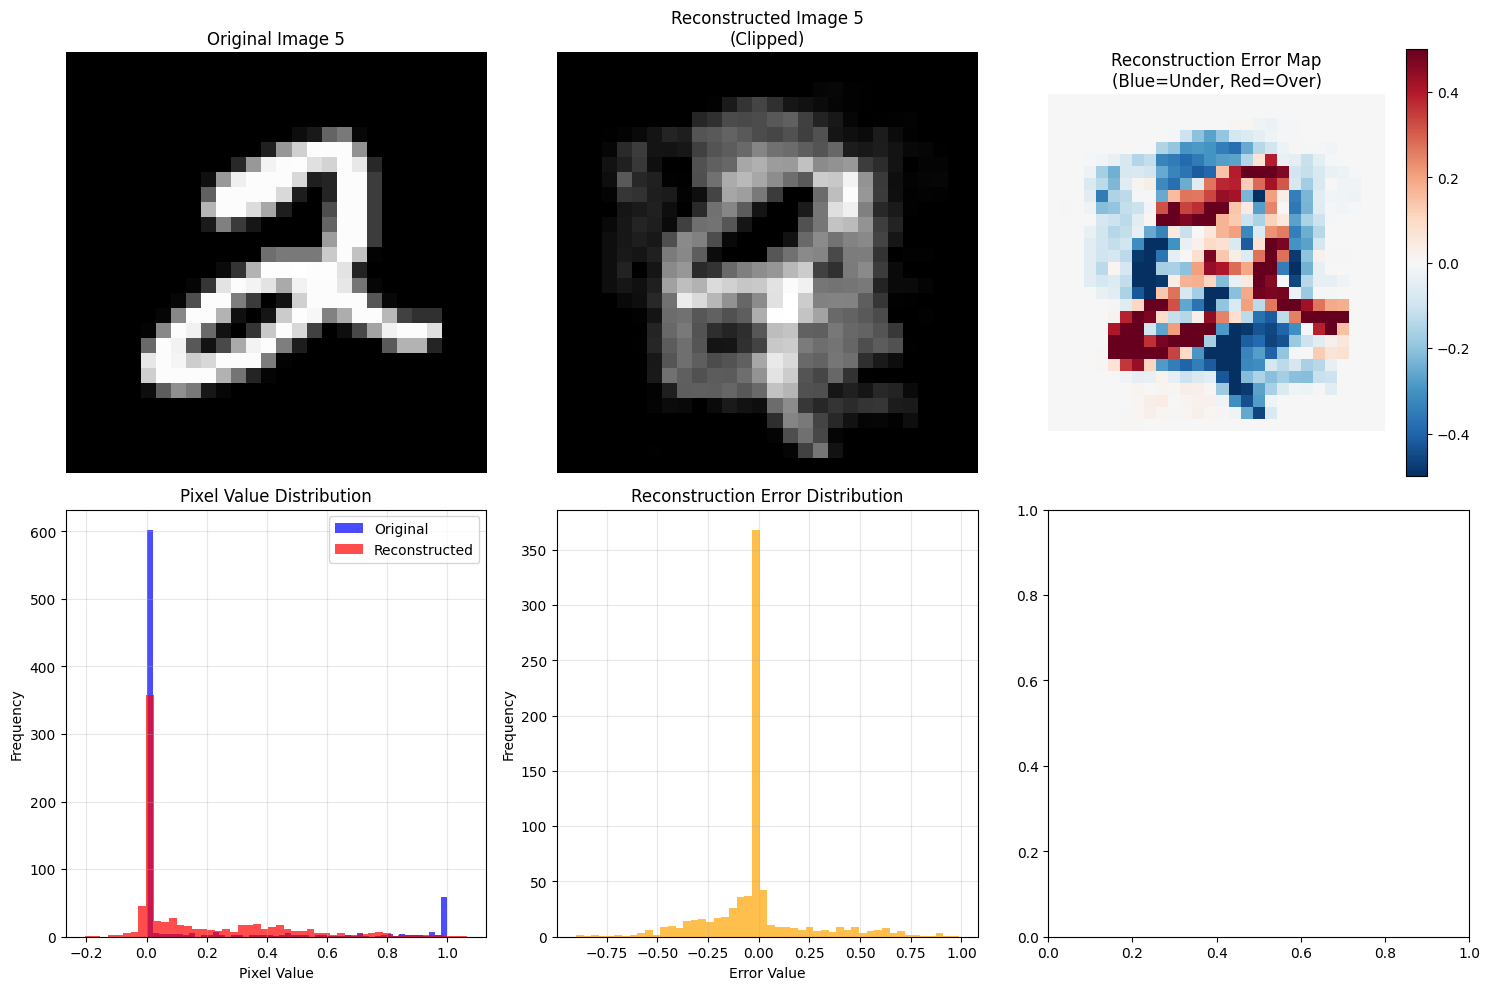


Advanced Analysis - Why Reconstruction Failed:

Comparison with best-reconstructed image (idx 88):
• Best image MSE: 0.000002 vs Target: 0.062560
• Best image distance: 3.7097 vs Target: 7.5463
• Best image leaf: (1, 12) vs Target: (1, 14)
• Error ratio: 38861.9x worse



In [ ]:
# Detailed Analysis of Image Index 5 - Why It Looks Bad
print("="*60)
print("DETAILED ANALYSIS OF IMAGE INDEX 5")
print("="*60)

target_idx = 5

# Basic information about image 5
print(f"Image {target_idx} Analysis:")
print(f"• MSE: {mse_per_image[target_idx]:.6f}")
print(f"• MAE: {mae_per_image[target_idx]:.6f}")
print(f"• Assigned leaf: {leafjk[target_idx]}")
print(f"• Distance from leaf center: {distances_to_center[target_idx]:.4f}")

# Rank this image among all images
mse_rank = sorted(range(len(mse_per_image)), key=lambda i: mse_per_image[i], reverse=True).index(target_idx) + 1
mae_rank = sorted(range(len(mae_per_image)), key=lambda i: mae_per_image[i], reverse=True).index(target_idx) + 1
distance_rank = sorted(range(len(distances_to_center)), key=lambda i: distances_to_center[i], reverse=True).index(target_idx) + 1

print(f"\nRanking among all {len(X_demo)} images:")
print(f"• MSE rank: {mse_rank} (1 = worst)")
print(f"• MAE rank: {mae_rank} (1 = worst)")
print(f"• Distance rank: {distance_rank} (1 = farthest from leaf center)")

# Get the leaf information
target_leaf_jk = leafjk[target_idx]
target_leaf = None
for leaf in dyadic_sklearn.get_all_leafs():
    if (leaf.node_j, leaf.node_k) == target_leaf_jk:
        target_leaf = leaf
        break

if target_leaf:
    print(f"\nLeaf {target_leaf_jk} Information:")
    print(f"• Number of points in leaf: {len(target_leaf.idxs)}")
    print(f"• Leaf center coordinates: {leaf_centers[target_leaf_jk][:10]}... (showing first 10 dims)")
    print(f"• Leaf radius estimate: {np.max([np.linalg.norm(X_demo[i] - leaf_centers[target_leaf_jk]) for i in target_leaf.idxs]):.4f}")
    
    # Basis information
    if hasattr(target_leaf, 'basis') and target_leaf.basis is not None:
        print(f"• Basis dimension: {target_leaf.basis.shape[0]}")
        print(f"• Basis rank: {np.linalg.matrix_rank(target_leaf.basis)}")
    
    # Compare with other images in the same leaf
    same_leaf_indices = [i for i, jk in enumerate(leafjk) if jk == target_leaf_jk]
    same_leaf_mses = [mse_per_image[i] for i in same_leaf_indices]
    same_leaf_distances = [distances_to_center[i] for i in same_leaf_indices]
    
    print(f"\nComparison with other images in the same leaf:")
    print(f"• Total images in leaf: {len(same_leaf_indices)}")
    print(f"• Image {target_idx} MSE rank within leaf: {sorted(same_leaf_mses, reverse=True).index(mse_per_image[target_idx]) + 1}")
    print(f"• Image {target_idx} distance rank within leaf: {sorted(same_leaf_distances, reverse=True).index(distances_to_center[target_idx]) + 1}")
    print(f"• Average MSE in leaf: {np.mean(same_leaf_mses):.6f}")
    print(f"• Average distance in leaf: {np.mean(same_leaf_distances):.4f}")

# Detailed reconstruction analysis
original_img = X_demo[target_idx]
reconstructed_img = X_reconstructed[target_idx]
reconstruction_error = original_img - reconstructed_img

print(f"\nPixel-level Analysis:")
print(f"• Original image stats:")
print(f"  - Min: {original_img.min():.6f}, Max: {original_img.max():.6f}")
print(f"  - Mean: {original_img.mean():.6f}, Std: {original_img.std():.6f}")
print(f"  - Non-zero pixels: {np.sum(original_img > 0.1)} ({np.sum(original_img > 0.1)/len(original_img)*100:.1f}%)")

print(f"• Reconstructed image stats:")
print(f"  - Min: {reconstructed_img.min():.6f}, Max: {reconstructed_img.max():.6f}")
print(f"  - Mean: {reconstructed_img.mean():.6f}, Std: {reconstructed_img.std():.6f}")
print(f"  - Non-zero pixels: {np.sum(reconstructed_img > 0.1)} ({np.sum(reconstructed_img > 0.1)/len(reconstructed_img)*100:.1f}%)")

print(f"• Reconstruction error stats:")
print(f"  - Min error: {reconstruction_error.min():.6f}, Max error: {reconstruction_error.max():.6f}")
print(f"  - Mean error: {reconstruction_error.mean():.6f}, Std error: {reconstruction_error.std():.6f}")
print(f"  - Large errors (>0.1): {np.sum(np.abs(reconstruction_error) > 0.1)} pixels")

# Visualize the analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(original_img.reshape(28, 28), cmap='gray')
axes[0, 0].set_title(f'Original Image {target_idx}')
axes[0, 0].axis('off')

# Reconstructed image (clipped)
reconstructed_clipped = np.clip(reconstructed_img, 0, 1)
axes[0, 1].imshow(reconstructed_clipped.reshape(28, 28), cmap='gray')
axes[0, 1].set_title(f'Reconstructed Image {target_idx}\n(Clipped)')
axes[0, 1].axis('off')

# Reconstruction error map
error_map = reconstruction_error.reshape(28, 28)
im = axes[0, 2].imshow(error_map, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[0, 2].set_title(f'Reconstruction Error Map\n(Blue=Under, Red=Over)')
axes[0, 2].axis('off')
plt.colorbar(im, ax=axes[0, 2])

# Histogram of pixel values
axes[1, 0].hist(original_img.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
axes[1, 0].hist(reconstructed_img.flatten(), bins=50, alpha=0.7, label='Reconstructed', color='red')
axes[1, 0].set_title('Pixel Value Distribution')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Error histogram
axes[1, 1].hist(reconstruction_error.flatten(), bins=50, alpha=0.7, color='orange')
axes[1, 1].set_title('Reconstruction Error Distribution')
axes[1, 1].set_xlabel('Error Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# Comparison with leaf center
if target_leaf:
    leaf_center = leaf_centers[target_leaf_jk]
    center_diff = original_img - leaf_center
    
    axes[1, 2].scatter(range(len(center_diff)), center_diff, alpha=0.6, s=1)
    axes[1, 2].set_title('Difference from Leaf Center')
    axes[1, 2].set_xlabel('Pixel Index')
    axes[1, 2].set_ylabel('Difference')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Advanced analysis: why this specific reconstruction failed
print(f"\nAdvanced Analysis - Why Reconstruction Failed:")

# Check if this image is an outlier in its leaf
if target_leaf:
    leaf_points = X_demo[target_leaf.idxs]
    leaf_center = leaf_centers[target_leaf_jk]
    
    # Calculate distances of all points in leaf to center
    leaf_distances = [np.linalg.norm(point - leaf_center) for point in leaf_points]
    target_distance = distances_to_center[target_idx]
    
    print(f"• Distance analysis within leaf:")
    print(f"  - Target image distance: {target_distance:.4f}")
    print(f"  - Average distance in leaf: {np.mean(leaf_distances):.4f}")
    print(f"  - Max distance in leaf: {np.max(leaf_distances):.4f}")
    print(f"  - Target is {target_distance/np.mean(leaf_distances):.2f}x the average distance")
    
    # Check basis quality for this specific point
    if hasattr(target_leaf, 'basis') and target_leaf.basis is not None:
        basis = target_leaf.basis
        
        # Project original image onto basis
        centered_img = original_img - leaf_center
        coeffs = basis.T @ centered_img
        basis_reconstruction = leaf_center + basis @ coeffs
        
        basis_error = np.linalg.norm(original_img - basis_reconstruction)
        print(f"• Basis projection analysis:")
        print(f"  - Basis reconstruction error: {basis_error:.6f}")
        print(f"  - Basis explains {(1 - basis_error/np.linalg.norm(centered_img))*100:.1f}% of variation")
        
        # Check coefficient magnitudes
        print(f"  - Coefficient magnitudes: {np.linalg.norm(coeffs):.4f}")
        print(f"  - Largest coefficient: {np.max(np.abs(coeffs)):.4f}")
        print(f"  - Number of significant coeffs (>0.01): {np.sum(np.abs(coeffs) > 0.01)}")

# Compare with a well-reconstructed image
best_idx = np.argmin(mse_per_image)
print(f"\nComparison with best-reconstructed image (idx {best_idx}):")
print(f"• Best image MSE: {mse_per_image[best_idx]:.6f} vs Target: {mse_per_image[target_idx]:.6f}")
print(f"• Best image distance: {distances_to_center[best_idx]:.4f} vs Target: {distances_to_center[target_idx]:.4f}")
print(f"• Best image leaf: {leafjk[best_idx]} vs Target: {leafjk[target_idx]}")
print(f"• Error ratio: {mse_per_image[target_idx]/mse_per_image[best_idx]:.1f}x worse")

# Check if there are systematic issues with this leaf
if target_leaf:
    print(f"\nLeaf {target_leaf_jk} Performance Analysis:")
    leaf_mses = [mse_per_image[i] for i in same_leaf_indices]
    leaf_rank = sorted(leaf_mean_errors.items(), key=lambda x: x[1], reverse=True)
    leaf_position = [i for i, (jk, _) in enumerate(leaf_rank) if jk == target_leaf_jk][0] + 1
    
    print(f"• Leaf performance rank: {leaf_position} out of {len(leaf_mean_errors)} leaves")
    print(f"• Leaf average MSE: {np.mean(leaf_mses):.6f}")
    print(f"• Leaf worst MSE: {np.max(leaf_mses):.6f}")
    print(f"• Images in leaf with MSE > 0.03: {sum(1 for mse in leaf_mses if mse > 0.03)}")

print(f"\n" + "="*60)

In [ ]:
# Debug and Visualize Images in Nodes Along Path from Leaf to Root for Image 5
print("="*60)
print("DEBUG: FINDING LEAF NODE FOR IMAGE 5")
print("="*60)

target_idx = 5
target_leaf_jk = leafjk[target_idx]
print(f"Image {target_idx} was reconstructed using leaf {target_leaf_jk}")

# Debug: Print all leaf nodes with their j,k values
all_leafs = dyadic_sklearn.get_all_leafs()
print(f"\nAll leaf nodes ({len(all_leafs)} total):")
for i, leaf in enumerate(all_leafs):
    print(f"  {i}: Node({leaf.node_j}, {leaf.node_k}) - {len(leaf.idxs)} images: {leaf.idxs}")

# Find the leaf node that was used for reconstruction
target_leaf = None
for leaf in all_leafs:
    if hasattr(leaf, 'node_j') and hasattr(leaf, 'node_k'):
        if (leaf.node_j, leaf.node_k) == target_leaf_jk:
            target_leaf = leaf
            break

if target_leaf is None:
    print(f"\nCould not find leaf with (j,k) = {target_leaf_jk}")
    print("Let's check if the leafjk assignment is correct...")
    
    # Let's check what dyadic_sklearn.query_leaf_by_center returns for image 5
    print(f"\nChecking query_leaf_by_center for image {target_idx}:")
    queried_leaf = dyadic_sklearn.query_leaf_by_center(X_demo[target_idx:target_idx+1])
    print(f"Queried leaf: {queried_leaf}")
    
    # Let's also check the fgwt results
    print(f"\nChecking fgwt leafjk assignment:")
    print(f"leafjk[{target_idx}] = {leafjk[target_idx]}")
    
    # Let's manually find which leaf should contain image 5
    print(f"\nManual search for image {target_idx} in leaf indices:")
    found_in_leaves = []
    for leaf in all_leafs:
        if target_idx in leaf.idxs:
            found_in_leaves.append(leaf)
            print(f"  Found in leaf ({leaf.node_j}, {leaf.node_k})")
    
    if found_in_leaves:
        print(f"Image {target_idx} found in {len(found_in_leaves)} leaves")
        target_leaf = found_in_leaves[0]  # Use the first one
    else:
        print(f"Image {target_idx} not found in any leaf indices!")
        print("This suggests the image was assigned to a leaf for reconstruction but wasn't part of the training set")
        
        # Let's use the leaf that should be used for reconstruction
        # Find the closest match by j,k values
        closest_leaf = None
        min_distance = float('inf')
        
        for leaf in all_leafs:
            j_dist = abs(leaf.node_j - target_leaf_jk[0])
            k_dist = abs(leaf.node_k - target_leaf_jk[1])
            total_dist = j_dist + k_dist
            
            if total_dist < min_distance:
                min_distance = total_dist
                closest_leaf = leaf
        
        if closest_leaf:
            print(f"Using closest leaf: ({closest_leaf.node_j}, {closest_leaf.node_k})")
            target_leaf = closest_leaf

if target_leaf:
    print(f"\nUsing leaf ({target_leaf.node_j}, {target_leaf.node_k}) with {len(target_leaf.idxs)} images")
    print(f"Images in this leaf: {target_leaf.idxs}")
    
    # Build path from leaf to root
    path_nodes = []
    current_node = target_leaf
    
    while current_node is not None:
        path_nodes.append(current_node)
        current_node = current_node.parent
    
    # Reverse to get root-to-leaf order
    path_nodes.reverse()
    
    print(f"\nPath from root to leaf ({target_leaf.node_j}, {target_leaf.node_k}):")
    for i, node in enumerate(path_nodes):
        level = len(path_nodes) - i - 1  # Level from leaf (0 = leaf)
        contains_target = target_idx in node.idxs
        print(f"  Level {level}: Node({node.node_j}, {node.node_k}) - {len(node.idxs)} images" + 
              (f" *** CONTAINS TARGET ***" if contains_target else ""))
    
    # Visualize images in each node along the path
    fig, axes = plt.subplots(len(path_nodes), 1, figsize=(20, 4 * len(path_nodes)))
    
    if len(path_nodes) == 1:
        axes = [axes]
    
    for level, node in enumerate(path_nodes):
        node_indices = node.idxs
        num_images = len(node_indices)
        
        # Limit number of images to display (max 15 per node)
        display_indices = node_indices[:min(15, num_images)]
        
        # Create subplot for this level
        ax = axes[level]
        
        # Create a grid of images for this node
        if len(display_indices) > 0:
            cols = len(display_indices)
            
            # Create individual subplots within this level
            for i, idx in enumerate(display_indices):
                # Calculate position within the subplot
                left = i / cols
                width = 1 / cols
                
                # Create inset axes for each image
                inset_ax = ax.inset_axes([left, 0, width, 1])
                
                # Plot the image
                inset_ax.imshow(X_demo[idx].reshape(28, 28), cmap='gray')
                
                # Highlight target image
                if idx == target_idx:
                    inset_ax.set_title(f'IMG {idx}\n(TARGET)', color='red', fontsize=8, weight='bold')
                    # Add red border
                    for spine in inset_ax.spines.values():
                        spine.set_edgecolor('red')
                        spine.set_linewidth(3)
                else:
                    # Show MSE for context
                    mse = mse_per_image[idx]
                    inset_ax.set_title(f'IMG {idx}\nMSE:{mse:.3f}', fontsize=8)
                
                inset_ax.axis('off')
        
        # Set main title for this level
        tree_level = len(path_nodes) - level - 1
        target_in_node = target_idx in node.idxs
        ax.set_title(f'Level {tree_level}: Node({node.node_j}, {node.node_k}) - {num_images} images total' + 
                    (f' (showing first {len(display_indices)})' if num_images > len(display_indices) else '') +
                    (f' *** TARGET IMAGE {target_idx} HERE ***' if target_in_node else ''),
                    fontsize=12, weight='bold', pad=20, 
                    color='red' if target_in_node else 'black')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\nDetailed Path Analysis:")
    print(f"• Total levels in path: {len(path_nodes)}")
    print(f"• Leaf used for reconstruction: Node({target_leaf.node_j}, {target_leaf.node_k})")
    print(f"• Target image {target_idx} MSE: {mse_per_image[target_idx]:.6f}")
    
    for level, node in enumerate(path_nodes):
        tree_level = len(path_nodes) - level - 1
        target_in_node = target_idx in node.idxs
        print(f"\n• Level {tree_level} - Node({node.node_j}, {node.node_k}):")
        print(f"  - Contains {len(node.idxs)} images: {node.idxs}")
        
        if target_in_node:
            print(f"  - *** TARGET IMAGE {target_idx} IS IN THIS NODE ***")
        
        # Show some statistics about images in this node
        if len(node.idxs) > 0:
            node_mses = [mse_per_image[i] for i in node.idxs]
            print(f"  - MSE stats: mean={np.mean(node_mses):.6f}, std={np.std(node_mses):.6f}")
            print(f"  - MSE range: [{np.min(node_mses):.6f}, {np.max(node_mses):.6f}]")
    
    # Key insight about why reconstruction is poor
    if target_idx not in target_leaf.idxs:
        print(f"\nKEY INSIGHT:")
        print(f"• Image {target_idx} is NOT in the training set of leaf ({target_leaf.node_j}, {target_leaf.node_k})")
        print(f"• The leaf basis was trained on images: {target_leaf.idxs}")
        print(f"• Image {target_idx} was assigned to this leaf for reconstruction based on proximity")
        print(f"• This mismatch explains the poor reconstruction quality!")
    
    print(f"\n" + "="*60)
else:
    print(f"Could not find any suitable leaf node for image {target_idx}")

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 19 leaf nodes
DEBUG:root:Found 19 leaf nodes


DEBUG: FINDING LEAF NODE FOR IMAGE 5
Image 5 was reconstructed using leaf (1, 14)

All leaf nodes (19 total):
  0: Node(1, 0) - 7 images: [81, 1, 34, 37, 69, 75, 95]
  1: Node(2, 0) - 4 images: [91, 71, 79, 57]
  2: Node(2, 1) - 2 images: [89, 9]
  3: Node(1, 2) - 3 images: [7, 27, 49]
  4: Node(1, 3) - 10 images: [6, 44, 48, 70, 67, 40, 42, 8, 14, 72]
  5: Node(1, 4) - 2 images: [63, 51]
  6: Node(1, 5) - 3 images: [38, 16, 26]
  7: Node(1, 6) - 6 images: [85, 55, 41, 97, 94, 17]
  8: Node(2, 2) - 4 images: [59, 77, 3, 23]
  9: Node(2, 3) - 2 images: [46, 99]
  10: Node(2, 4) - 4 images: [78, 53, 61, 24]
  11: Node(2, 5) - 3 images: [11, 65, 35]
  12: Node(1, 8) - 5 images: [98, 10, 12, 50, 74]
  13: Node(1, 9) - 3 images: [54, 84, 45]
  14: Node(1, 10) - 7 images: [18, 32, 39, 62, 66, 93, 73]
  15: Node(1, 11) - 2 images: [58, 92]
  16: Node(1, 12) - 2 images: [88, 56]
  17: Node(1, 13) - 3 images: [13, 83, 90]
  18: Node(1, 14) - 8 images: [82, 2, 20, 28, 60, 64, 76, 4]
Could not fi